# Apply YOLO style Model For OCR

## An effectient one-shot deep detwork for OCR

After some searching, I didn't find any dataset with image+character label+ single char level bounding box。

So the most direct solution: Create a scene text detection data generator

In [1]:
from torch.utils.data import dataset
from torch.utils.data import DataLoader
from constant import *
from constant_char import *
import numpy as np
from glob import glob
from PIL import Image

from p3self.matchbox import *
from utils import *

In [2]:
len(IDX2CHARS)

3566

### Texted image generator

In [3]:

from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw 
import os
from char_data import Make_Char,rd,rd_font,Make_Char_cn

# rg_n,rg_l,rg_u,rg_c,

# fonts

### Generate Image with Characters

In [4]:
from tqdm import trange
import os

if REBUILD_DATA:
    
    os.system("rm %s*"%(IMG))
    mc = Make_Char(img_dir = IMG_EPT,forge_dir=IMG)
    dl = DataLoader(mc,batch_size=4,shuffle=True)
    mc_gen=iter(dl)

    if EXPERIMENT:
        t=trange(3)
    else:
        t=trange(len(dl))

    for i in t:_ = next(mc_gen)
    mc.df_dicts = list(d for d in mc.df_dicts if type(d)!= dict)
    pd.concat(mc.df_dicts,axis=0).to_csv(ANN)
    
    if TRAIN_CLS:
        os.system("rm %s*"%(IMG_CLS))
        mc2 = Make_Char_cn(img_dir = IMG_EPT,forge_dir=IMG_CLS)
        dl2 = DataLoader(mc2,batch_size=4,shuffle=True)
        mc_gen2=iter(dl2)

        if EXPERIMENT:
            t=trange(3)
        else:
            t=trange(len(dl))

        for i in t:_ = next(mc_gen2)
        mc2.df_dicts = list(d for d in mc2.df_dicts if type(d)!= dict)
        pd.concat(mc2.df_dicts,axis=0).to_csv(ANN_CLS)

100%|██████████| 3/3 [00:02<00:00,  1.13it/s]


### Prepare Data

In [5]:
ann_df = pd.read_csv(ANN)
if TRAIN_CLS:ann_df2 = pd.read_csv(ANN_CLS)
# ann_df.sample(5)

In [6]:
urls = glob(IMG_CLS+"/*")

rdimg = np.random.choice(urls)
def get_id(url):
    return url.split("/")[-1]

def get_bb(rdimg):
    match = ann_df2[ann_df2["image_id"]==get_id(rdimg)][["bbox","category_id"]]
    return list(match["bbox"]),list(match["category_id"])

get_bb(rdimg)

(['[96, 96, 24, 30]',
  '[160, 192, 26, 26]',
  '[0, 64, 26, 28]',
  '[32, 0, 33, 44]',
  '[192, 192, 30, 29]',
  '[192, 160, 21, 24]',
  '[160, 64, 22, 23]',
  '[64, 32, 25, 29]',
  '[256, 224, 25, 24]',
  '[96, 192, 24, 27]',
  '[0, 288, 21, 27]',
  '[0, 160, 29, 35]',
  '[160, 96, 32, 40]',
  '[64, 256, 20, 24]',
  '[288, 224, 25, 24]',
  '[0, 128, 25, 33]',
  '[0, 256, 17, 20]',
  '[288, 128, 19, 20]',
  '[96, 288, 17, 24]',
  '[160, 160, 18, 24]',
  '[32, 288, 24, 23]',
  '[192, 256, 30, 43]',
  '[288, 96, 24, 34]',
  '[64, 128, 15, 15]',
  '[96, 128, 17, 19]',
  '[128, 224, 25, 29]',
  '[128, 128, 28, 39]',
  '[32, 192, 25, 24]',
  '[64, 96, 23, 27]',
  '[128, 0, 23, 28]',
  '[64, 64, 36, 36]',
  '[0, 32, 18, 23]',
  '[0, 224, 21, 27]',
  '[32, 96, 18, 26]',
  '[128, 160, 26, 29]',
  '[288, 64, 16, 16]',
  '[128, 288, 29, 33]',
  '[256, 0, 22, 27]',
  '[64, 224, 18, 33]',
  '[192, 224, 13, 14]',
  '[224, 32, 13, 15]',
  '[224, 128, 30, 35]',
  '[256, 32, 19, 21]',
  '[192, 96, 26

In [7]:
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import matplotlib.text as text
%matplotlib inline
import matplotlib

In [8]:
msyh = matplotlib.font_manager.FontProperties(fname='/data/fonts_cn/msyh.ttf')

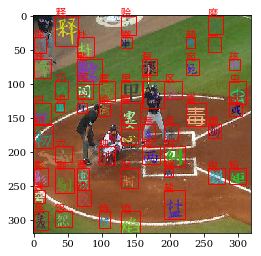

In [9]:
fig,ax = plt.subplots(1)
ax.imshow(Image.open(rdimg).resize((HEIGHT,WIDTH)))
bbs,cids = get_bb(rdimg)
# font_label = ImageFont.FreeTypeFont("/data/fonts_cn/msyh.ttf", 5)
for i in range(len(bbs)):
    bb=eval(bbs[i])
    # format of the bb: x, y, width, height
    rect = patches.Rectangle((bb[0],bb[1]),bb[2],bb[3],linewidth=1,edgecolor='r',facecolor='none')

    ax.add_patch(rect)
    # format of bb 
    ax.text(bb[0],bb[1],idx2name[cids[i]],dict({"color":"#ff0000"}),fontproperties=msyh)
    # print(idx2name[cids[i]])

In [10]:
import torch
from torch import nn
from torch.autograd import Variable
from torch.nn import functional as F

In [11]:
def df_data(ann_df,shuffle=True):
    """
    imgdf:
    A dataframe about images, fields: "id","file_name","height","width"
    ann_df:
    A dataframe about annotation, fields: "image_id","category_id","bbox",
    The field "bbox" is a list of 4 values: x,y,height, width of the bounding box
    """
    data_df=ann_df
    
    data_df["cate_id_oh"] = data_df["category_id"].apply(lambda x:idx2id[x])
    data_df["bbox"] = data_df["bbox"].apply(lambda x:eval(x))
    if shuffle:
        data_df = data_df.sample(frac=1).reset_index(drop=True)
    print("total data rows",len(data_df))
    data_df["width"] = data_df["category_id"].apply(lambda x:WIDTH)
    data_df["height"] = data_df["category_id"].apply(lambda x:HEIGHT)
    return data_df

data_df = df_data(ann_df)
data_df.head()

total data rows 222


,Unnamed: 0,bbox,category_id,file_name,image_id,cate_id_oh,width,height
0,14,"[217, 229, 29, 37]",52,000000345469.jpg,000000345469.jpg,52,320,320
1,18,"[83, 196, 25, 28]",2736,000000089271.jpg,000000089271.jpg,2736,320,320
2,16,"[35, 127, 20, 24]",3521,000000345469.jpg,000000345469.jpg,3521,320,320
3,1,"[253, 215, 27, 29]",0,000000345469.jpg,000000345469.jpg,0,320,320
4,16,"[0, 264, 32, 31]",3266,000000289415.jpg,000000289415.jpg,3266,320,320


Adjust the bounding box

In [12]:
bbox_array = np.array(data_df.bbox.tolist()).astype(np.float64)
wh_array = data_df[["width","height"]].as_matrix().astype(np.float64)

def re_calibrate(bbox_array,wh_array):
    """return the resized bbox array"""
    bb_resized = (bbox_array/np.concatenate([wh_array,wh_array],axis=-1)) *SIZE
    
    true_bb = bb_resized/SCALE
    # switch xy as left top conner to center point
    true_bb[...,:2]=true_bb[...,:2]+true_bb[...,2:]/2
    # Labels' Anchor positions on the grid map
    grid_bbxy = np.floor(true_bb[...,:2])
    return bb_resized,true_bb,grid_bbxy

def find_best_anchors(true_bbwh):
    iou_score = []
    for b in range(BOX):
        wh_anc = np.tile(ANC_ARR[b],[true_bbwh.shape[0],1])
        true_area = true_bbwh.prod(axis=-1)
        anc_area = wh_anc.prod(axis=-1)
    
        inter_area = np.min([wh_anc,true_bbwh],axis=0).prod(axis=-1)
    
        union_area = true_area + anc_area - inter_area
        iou_score.append(inter_area/union_area)
    best_anchor_idx = np.array(iou_score).T.argmax(axis=-1)
    return best_anchor_idx

bb_resized,true_bb,grid_bbxy = re_calibrate(bbox_array,wh_array)
true_bbxy,true_bbwh = true_bb[...,:2],true_bb[...,2:]
best_anchor_idx = find_best_anchors(true_bbwh)

min_lbl = SCALE * 0.001

data_df["true_bb_x"],data_df["true_bb_y"],data_df["true_bb_w"],data_df["true_bb_h"]=true_bb[:,0],true_bb[:,1],true_bb[:,2],true_bb[:,3]
data_df["true_grid_x"],data_df["true_grid_y"]=grid_bbxy[:,0],grid_bbxy[:,1]

data_df["best_anchor"]=best_anchor_idx
data_df_ = data_df[data_df["true_bb_w"]>min_lbl]
data_df_ = data_df_[data_df_["true_bb_h"]>min_lbl]
data_df_["only_cls"]=1 # train the full loss function

## cls data

In [13]:
if TRAIN_CLS:
    data_df2 = df_data(ann_df2)
    data_df2.head()

    bbox_array2 = np.array(data_df2.bbox.tolist()).astype(np.float64)
    wh_array2 = data_df2[["width","height"]].as_matrix().astype(np.float64)

    bb_resized2,true_bb2,grid_bbxy2 = re_calibrate(bbox_array2,wh_array2)
    true_bbxy2,true_bbwh2 = true_bb2[...,:2],true_bb2[...,2:]
    best_anchor_idx2 = find_best_anchors(true_bbwh2)

    min_lbl2 = SCALE * 0.001

    data_df2["true_bb_x"],data_df2["true_bb_y"],data_df2["true_bb_w"],data_df2["true_bb_h"]=true_bb2[:,0],true_bb2[:,1],true_bb2[:,2],true_bb2[:,3]
    data_df2["true_grid_x"],data_df2["true_grid_y"]=grid_bbxy2[:,0],grid_bbxy2[:,1]

    data_df2["best_anchor"]=best_anchor_idx2
    data_df_cls = data_df2[data_df2["true_bb_w"]>min_lbl2]
    data_df_cls = data_df_cls[data_df_cls["true_bb_h"]>min_lbl2]

    data_df_cls["only_cls"]=0 # only train the classification part

    # Mix and shuffle the "train all loss" and "train classification only"
    data_df_ = pd.concat([data_df_,data_df_cls],axis=0).sample(frac=1.).reset_index()

total data rows 600


#### Reverse adjust funtion to get train labels

* t to b

$\large b_{x}=\sigma(t_{x})+c_{x}$

$\large b_{y}=\sigma(t_{y})+c_{y}$

$\large b_{w}=p_{w}e^{w}$

$\large b_{h}=p_{h}e^{h}$

* b to t

$\large t_{x}=-ln(\frac{1}{b_{x}-c_{x}}-1)$

$\large t_{y}=-ln(\frac{1}{b_{y}-c_{y}}-1)$

$\large t_{w}=ln(\frac{b_{w}}{p_{w}})$

$\large t_{h}=ln(\frac{b_{h}}{p_{h}})$

In [14]:
from conv_model import dn121_conv

dn121=dn121_conv(DN121)

In [15]:
class dn_yolo(nn.Module):
    def __init__(self,feat_extra,feat_in):
        super(dn_yolo,self).__init__()
        self.feat_in = feat_in
        self.feat_extra=feat_extra
        
        self.conv_1 = nn.Conv2d(self.feat_in,feat_in,kernel_size=(3,3),stride=(1,1),padding=1,bias=False)
        self.conv_2 = nn.Conv2d(self.feat_in,feat_in,kernel_size=(3,3),stride=(1,1),padding=1,bias=False)
        self.conv_3 = nn.Conv2d(self.feat_in,VEC_LEN*BOX,kernel_size=(1,1),stride=(1,1),padding=0,bias=False)
        self.bn1 = nn.BatchNorm2d(self.feat_in)
        self.bn2 = nn.BatchNorm2d(self.feat_in)
        self.bn3 = nn.BatchNorm2d(self.feat_in)
    
    def forward(self,x):
        
        x = self.feat_extra(x)
        
        x = self.bn1(x)
        x = self.conv_1(x)
        x = self.bn2(x)
        x = self.conv_2(x)
        x = self.bn3(x)
        x = self.conv_3(x)
        
        # from: bs,channel, height, width
        # to: bs, width, height, channel
        x = x.permute([0,3,2,1]).contiguous().view(-1,FEAT_W,FEAT_H,BOX,VEC_LEN)
        
        return x

## Data Generator

In [16]:
from torch.utils.data import DataLoader,dataset
from torchvision import transforms
from PIL import Image

In [17]:
transform = transforms.Compose([transforms.Resize((HEIGHT,WIDTH)),
                                transforms.ToTensor(),
                                transforms.Normalize([.5,.5,.5],[.5,.5,.5])
                               ])
trans_origin = transforms.Compose([transforms.Resize((HEIGHT,WIDTH)),
                                transforms.ToTensor(),
                               ])
back2PIL = transforms.Compose([transforms.ToPILImage(mode="RGB")])

## Training

In [18]:
from torch.utils.data import DataLoader
from tqdm import trange
from datetime import datetime
import os

In [19]:
from data import Data_Multi

In [20]:
train_set = Data_Multi(data_df=data_df_,
                       train_cls=TRAIN_CLS,
                       transform=transform,
                       trans_origin=trans_origin)

In [21]:
trainer=Trainer(train_set,batch_size=16,print_on=5)
model = dn_yolo(dn121,1024)
if TRAIN_CLS:
    from loss_ import yolo3_loss_train_cls as yolo3_loss
else:
    from loss_ import yolo3_loss_on_t as yolo3_loss


In [22]:
# Loss function lambdas
loss_func = yolo3_loss(lbd_coord=LBD_COORD,lbd_obj=LBD_OBJ,
                       lbd_noobj=LBD_NOOBJ,lbd_cls=LBD_CLS,
                       testing=False,train_all=True)

In [23]:
CUDA = torch.cuda.is_available()
if CUDA:
    torch.cuda.empty_cache()
    model.cuda()
    loss_func.cuda()

In [24]:
from torch.optim import Adam
optimizer = Adam(model.parameters(),)

In [25]:
def action(*args,**kwargs):
    """
    y_s: label for scoring, because the y's bb has been transformed into t
    """
    if TRAIN_CLS:
        x,original, t_box, conf_, cls_, mask, b_box,only_cls = args[0]
    else:
        x,original, t_box, conf_, cls_, mask, b_box = args[0]
    iteration=kwargs["ite"]
    # x,t_box, conf_, cls_, mask, cls_mask, b_box = Variable(x), Variable(t_box), Variable(conf_), Variable(cls_), Variable(mask), Variable(cls_mask), Variable(b_box)
    if CUDA:
        x,t_box, conf_, cls_, mask, b_box = x.cuda(),t_box.cuda(), conf_.cuda(), cls_.cuda(), mask.cuda(),  b_box.cuda()
        if TRAIN_CLS:
            only_cls = only_cls.cuda()
    
    optimizer.zero_grad()
    
    y_ = model(x)
    model.x,model.y_=x,y_
    
    # train class only
    if TRAIN_CLS:
        loss,loss_x,loss_y,loss_w,loss_h,loss_obj,loss_noobj,loss_cls = loss_func(y_,t_box, conf_, cls_, mask, b_box, only_cls)
    else:
        loss,loss_x,loss_y,loss_w,loss_h,loss_obj,loss_noobj,loss_cls = loss_func(y_,t_box, conf_, cls_, mask, b_box)
    loss.backward()

    optimizer.step()

    if iteration%30==0:
        y_pred = loss_func.t2b(y_)[0:1,...]
        if CUDA:
            y_pred = y_pred.cpu()
        img = back2PIL(original[0])
        printimg = plot_bb(img,data_to_df_bmark(y_pred))
    return {"loss":loss.item(),
            "loss_x":loss_x.item(),
            "loss_y":loss_y.item(),
            "loss_w":loss_w.item(),
            "loss_h":loss_h.item(),
            "loss_obj":loss_obj.item(),
            "loss_noobj":loss_noobj.item(),
            "loss_cls":loss_cls.item(),}

trainer.action=action

  0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([16, 10, 10, 2, 1])


 50%|█████     | 1/2 [01:35<01:35, 95.51s/it]

torch.Size([8, 10, 10, 2, 1])


  0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([16, 10, 10, 2, 1])


 50%|█████     | 1/2 [01:48<01:48, 108.20s/it]

torch.Size([8, 10, 10, 2, 1])


100%|██████████| 2/2 [02:21<00:00, 70.78s/it] 


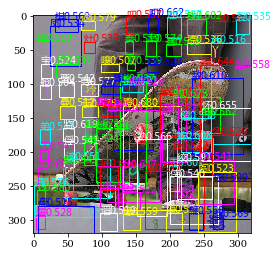

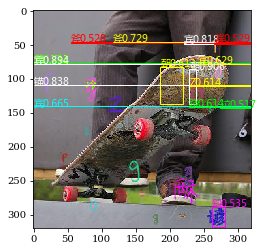

In [26]:
trainer.train(2)

In [27]:
dl = DataLoader(train_set,batch_size=2,shuffle=True)
d_gen = iter(dl)
for i in range(len(dl)):_ = next(d_gen)

In [28]:
_[-1]

tensor([ 0,  0])

In [29]:
train_set.data_df["true_grid_x"].max()

9.0